# What are the significant relationships between features and responder_6, and how can statistical tests validate or invalidate these relationships? #

## Dataset Description


Thanks to Jane Street 2024 competition, the dataset consists of timeseries data with 79 anonymized features and 9 responders, derived from real market data. The task is to forecast responder_6 for up to six months. 

Train Data: Historical data partitioned into ten parts, with columns for date_id, time_id, symbol_id, 79 feature_{00...78} columns, and 9 responder_{0...8} columns.
Test Data: A mock test set structured similarly to the training data, provided in batches via an evaluation API.
Lags: Previous day’s responder values, available at the first time_id of each new day.


For this EDA and Statistical analysis i will only be considering the last partition, which might contain more recent data that may align better with the patterns in the unseen test set. 

In [1]:
%%time
import os
import gc
import random
import pandas as pd
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from math import log, sqrt
from scipy.stats import (ttest_1samp, pearsonr, spearmanr, f_oneway, shapiro, kstest, norm, chi2)
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import kaggle_evaluation.jane_street_inference_server
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


responders = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv')
features = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv')
sample_submission = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv')

train = (
    pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=9/part-0.parquet')
)

train = train.to_pandas()

CPU times: user 11.5 s, sys: 8.33 s, total: 19.9 s
Wall time: 15.8 s


### Basic introduction ###
Partition 9 consists of 6274576 rows and 92 columns

In [2]:
print("Shape of the dataset:", train.shape)
print(train.info())
#print(train.describe())

Shape of the dataset: (6274576, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274576 entries, 0 to 6274575
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   f

### Missing values

33 features have missing values, with 4 features having more than 7% missing values

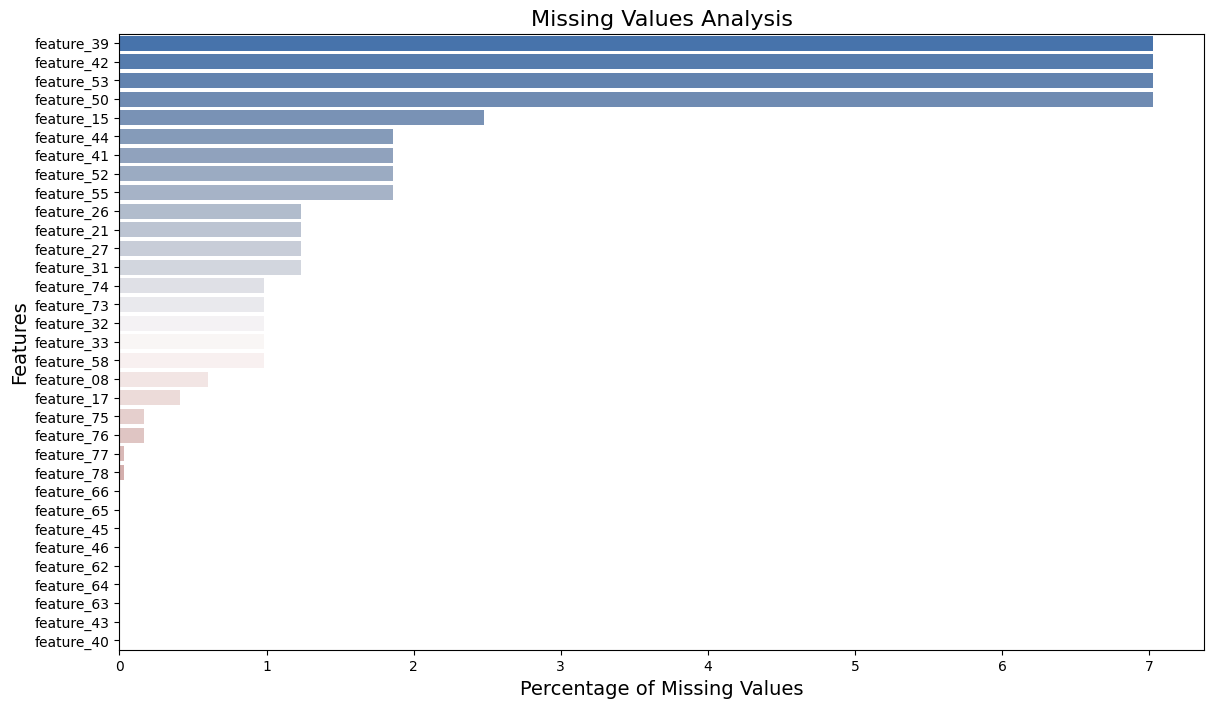

Number of features with missing values :  33


Feature  MissingCount  MissingPercentage
feature_39  feature_39        440778           7.024825
feature_42  feature_42        440778           7.024825
feature_53  feature_53        440776           7.024793
feature_50  feature_50        440776           7.024793
feature_15  feature_15        155568           2.479339
feature_44  feature_44        116677           1.859520
feature_41  feature_41        116677           1.859520
feature_52  feature_52        116676           1.859504
feature_55  feature_55        116676           1.859504
feature_26  feature_26         77440           1.234187
feature_21  feature_21         77440           1.234187
feature_27  feature_27         77440           1.234187
feature_31  feature_31         77440           1.234187
feature_74  feature_74         61707           0.983445
feature_73  feature_73         61707           0.983445
feature_32  feature_32         61545           0.980863
feature_33  feature_33         61545           0.980863
feature_58  feature_58         61545           0.980863
feature_08  feature_08         37752           0.601666
feature_17  feature_17         25928           0.413223
feature_75  feature_75         10480           0.167023
feature_76  feature_76         10480           0.167023
feature_77  feature_77          1945           0.030998
feature_78  feature_78          1945           0.030998
feature_66  feature_66           139           0.002215
feature_65  feature_65           139           0.002215
feature_45  feature_45           139           0.002215
feature_46  feature_46           139           0.002215
feature_62  feature_62           126           0.002008
feature_64  feature_64           101           0.001610
feature_63  feature_63            96           0.001530
feature_43  feature_43             2           0.000032
feature_40  feature_40             2           0.000032

In [3]:
missing_values = train.isnull().sum()
missing_percentage = (missing_values / train.shape[0]) * 100

missing_data = pd.DataFrame({
    "Feature": train.columns,
    "MissingCount": missing_values,
    "MissingPercentage": missing_percentage
}).sort_values(by="MissingPercentage", ascending=False)

# threshold > 0% 33 features
# threshold > 1% 13 features
# threshold > 5% 4 features
missing_data_filtered = missing_data[missing_data["MissingPercentage"] > 0]

plt.figure(figsize=(14, 8))
sns.barplot(
    x="MissingPercentage",
    y="Feature",
    data=missing_data_filtered,
    palette="vlag"
)
plt.title("Missing Values Analysis", fontsize=16)
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.show()

print("Number of features with missing values : ", len(missing_data_filtered))
missing_data_filtered

### Responder_6 distribution

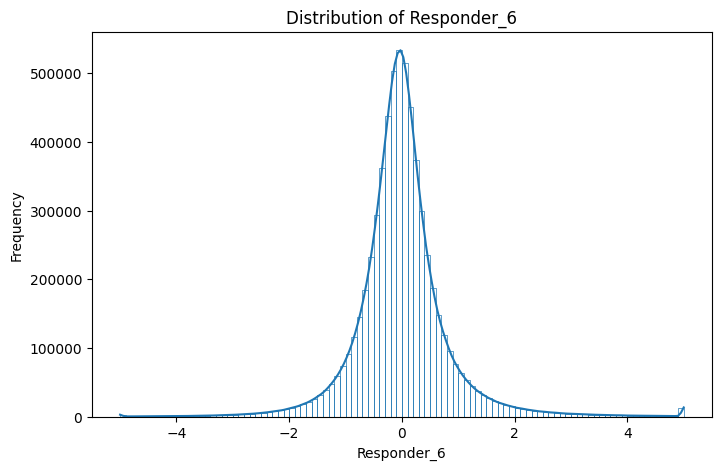

Proportion of all Responder_6: -0.38%
Proportion of exact zeros in Responder_6: 0.00%


In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(train['responder_6'], bins=100, kde=True,fill=False)
plt.title("Distribution of Responder_6")
plt.xlabel("Responder_6")
plt.ylabel("Frequency")
plt.show()

all_response = train['responder_6'].mean() * 100
print(f"Proportion of all Responder_6: {all_response:.2f}%")

zero_response = (train['responder_6'] == 0).mean() * 100
print(f"Proportion of exact zeros in Responder_6: {zero_response:.2f}%")

The mean of responder_6 is -0.38%, indicating a slight negative bias, and also no exact zeros are present in the data.
The distribution of responder_6 looks roughly symmetric and bell-shaped, kind of like a normal distribution. But to be sure, it could be interesting to run some normality test, to check later if it really follows a normal law, even if it seems useless in our real world, https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless.

## Date_id and Time_id

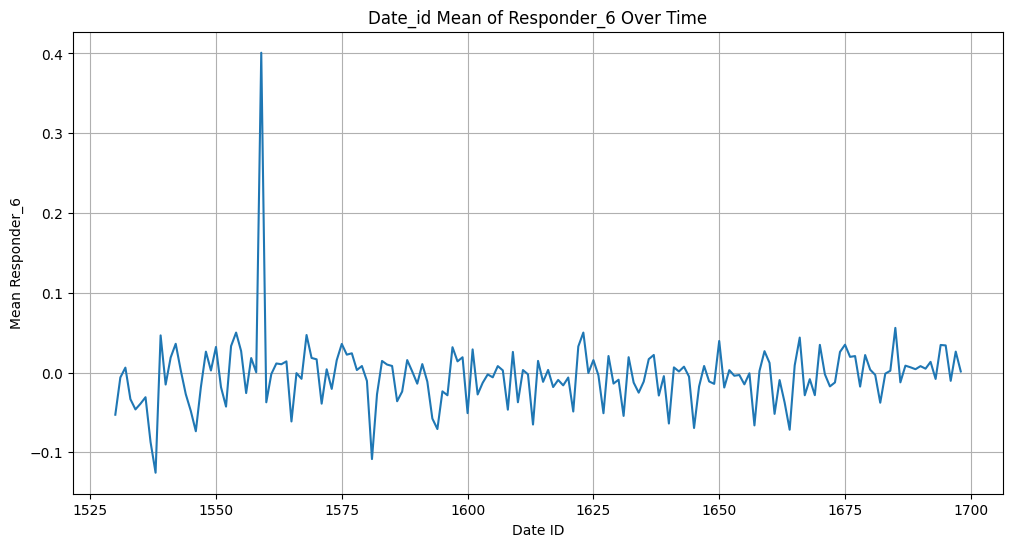

In [5]:
daily_mean = train.groupby('date_id')['responder_6'].mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_mean)
plt.title("Date_id Mean of Responder_6 Over Time")
plt.xlabel("Date ID")
plt.ylabel("Mean Responder_6")
plt.grid()
plt.show()

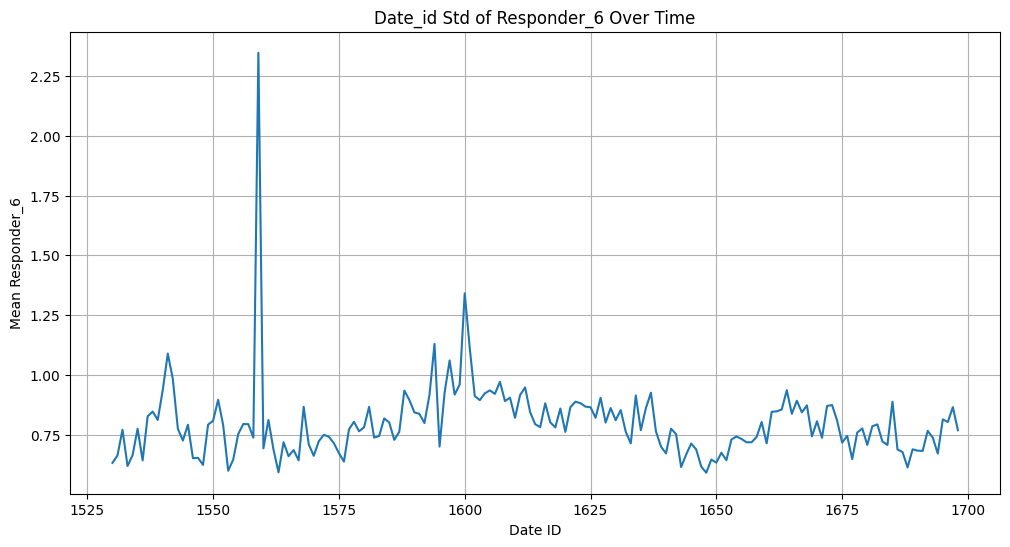

In [6]:
daily_std = train.groupby('date_id')['responder_6'].std()
plt.figure(figsize=(12, 6))
plt.plot(daily_std)
plt.title("Date_id Std of Responder_6 Over Time")
plt.xlabel("Date ID")
plt.ylabel("Mean Responder_6")
plt.grid()
plt.show()


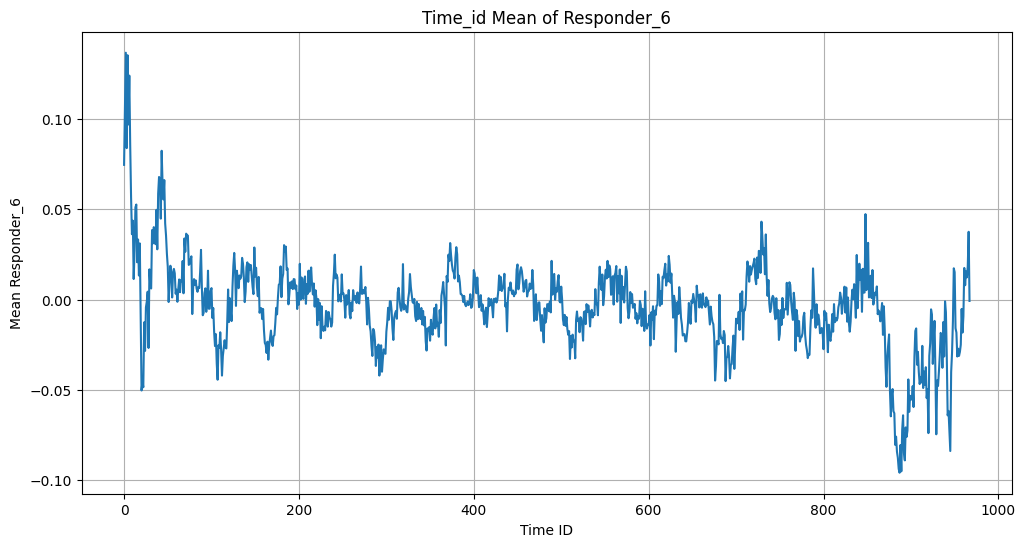

In [7]:
intraday_mean = train.groupby('time_id')['responder_6'].mean()
plt.figure(figsize=(12, 6))
plt.plot(intraday_mean)
plt.title("Time_id Mean of Responder_6")
plt.xlabel("Time ID")
plt.ylabel("Mean Responder_6")
plt.grid()
plt.show()

The dataset has in total for partition_6 169 days and 968 time steps per day every day.

Unique date-id: 169
Total Unique time_id steps: 968

Time Steps per Day:
count    169.0
mean     968.0
std        0.0
min      968.0
25%      968.0
50%      968.0
75%      968.0
max      968.0
Name: time_id, dtype: float64

Rows per Day:
count      169.000000
mean     37127.668639
std       1574.901564
min      26136.000000
25%      36784.000000
50%      37752.000000
75%      37752.000000
max      37752.000000
Name: count, dtype: float64


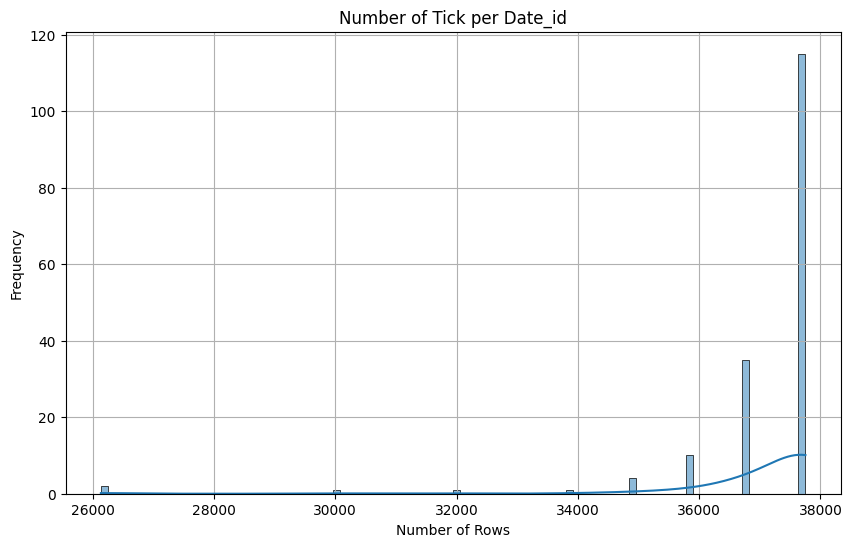

In [8]:
print("Unique date-id:", train['date_id'].nunique())
print("Total Unique time_id steps:", train['time_id'].nunique())


time_per_day = train.groupby('date_id')['time_id'].nunique()
print("\nTime Steps per Day:")
print(time_per_day.describe()) 


### time_id per date_id
rows_per_day = train['date_id'].value_counts()
print("\nRows per Day:")
print(rows_per_day.describe())

plt.figure(figsize=(10, 6))
sns.histplot(rows_per_day, bins=100, kde=True)
plt.title("Number of Tick per Date_id")
plt.xlabel("Number of Rows")
plt.ylabel("Frequency")
plt.grid()
plt.show()

Checking for a specific date_id 1530

Number of time_id for date_id 1530: 35816
from  0 to 967


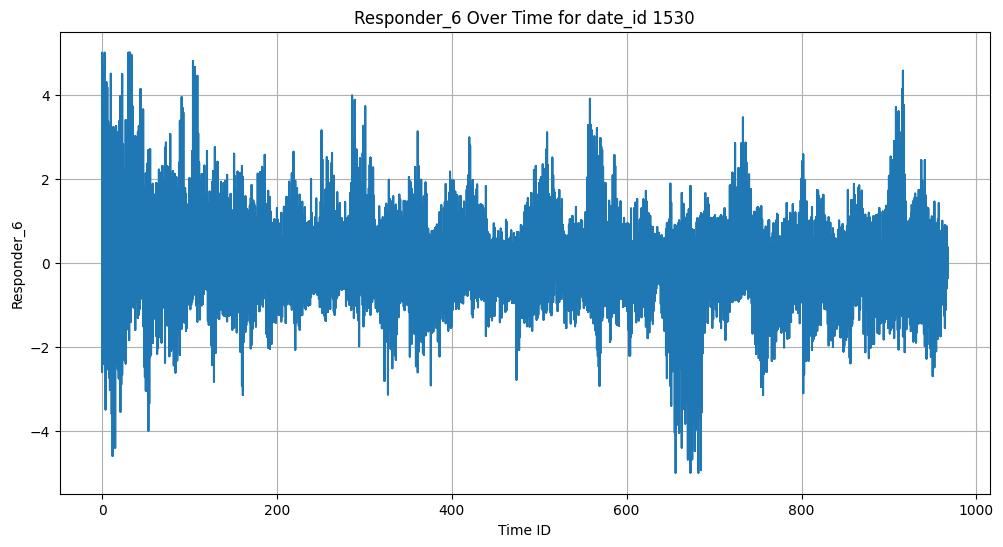

In [9]:
specific_date = 1530
train_one_day = train[train['date_id'] == specific_date]
print(f"Number of time_id for date_id 1530: {train_one_day.shape[0]}")

print("from ", train_one_day['time_id'].min(), "to", train_one_day['time_id'].max())

plt.figure(figsize=(12, 6))
plt.plot(train_one_day['time_id'], train_one_day['responder_6'])
plt.title(f"Responder_6 Over Time for date_id {specific_date}")
plt.xlabel("Time ID")
plt.ylabel("Responder_6")
plt.grid()
plt.show()


The weight distribution is right-skewed, with most values between 1 and 3, which should be analyzed further.

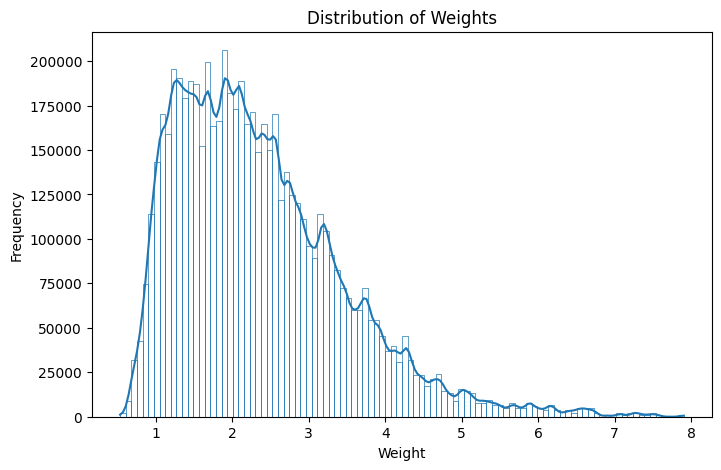

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(train['weight'], bins=100, kde=True,fill=False)
plt.title("Distribution of Weights")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

## Symbol_id 

The cumulative returns of responder_6 show significant divergence across all symbol_id values. Symbols exhibit varying levels of volatility and form clusters of similar behaviors. This suggests that symbol_id influences the performance of responder_6 over time and warrants further analysis. And the big peak at circa 1.2 seems to be correlated with the same high std seen in date_id plot. Finding this exact value and delete it may help.

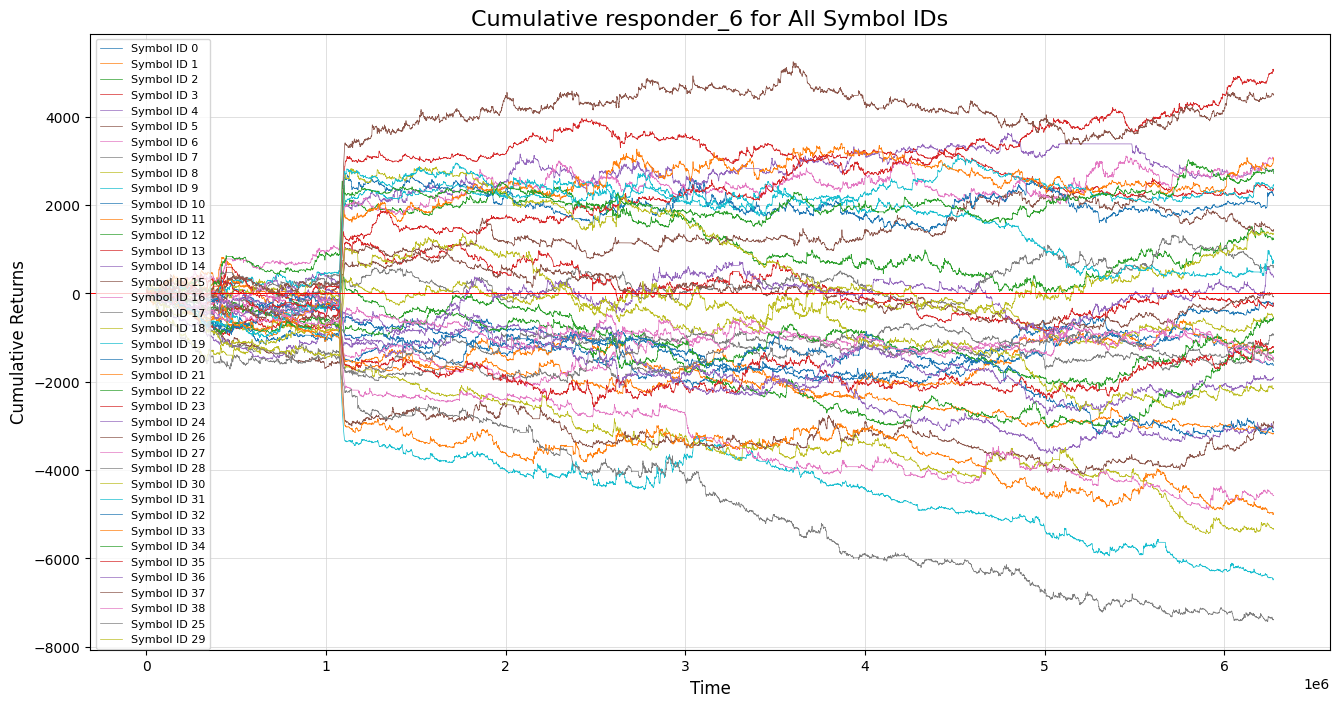

In [11]:
train['id'] = train.index.values

plt.figure(figsize=(16, 8))
for symbol_id in train['symbol_id'].unique():
    xx = train[train['symbol_id'] == symbol_id]['id']
    yy = train[train['symbol_id'] == symbol_id]['responder_6']
    plt.plot(xx, yy.cumsum(), label=f'Symbol ID {symbol_id}', linewidth=0.5)

plt.title('Cumulative responder_6 for All Symbol IDs', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.grid(color='lightgray', linewidth=0.5)
plt.axhline(0, color='red', linestyle='-', linewidth=0.7)
plt.legend(loc='upper left', fontsize=8)
plt.show()

All responders cumulative sum comparison, Responder_6 has the same pattern as Responder_7 and Responder_8.

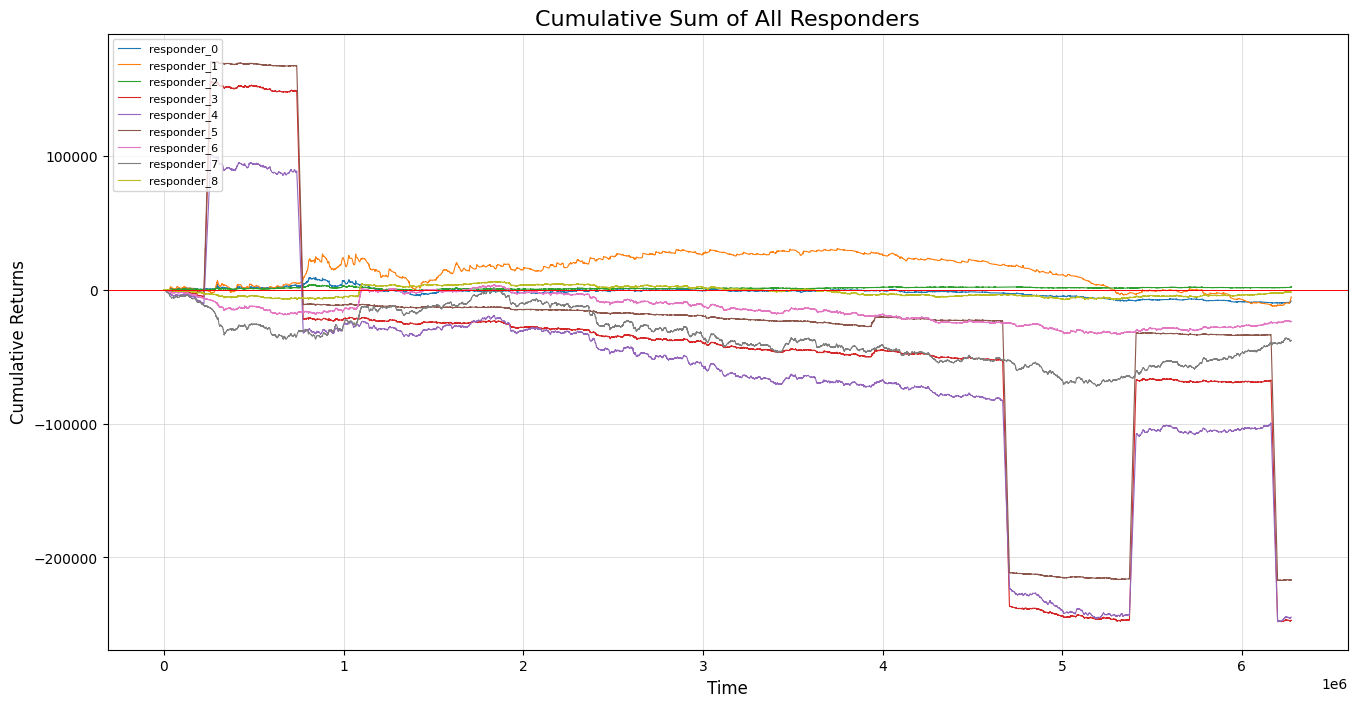

In [12]:
responders = ['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8']
plt.figure(figsize=(16, 8))

for responder in responders:
    cumulative_sum = train.groupby('id')[responder].sum().cumsum()
    plt.plot(cumulative_sum, label=f'{responder}', linewidth=0.8)

plt.title('Cumulative Sum of All Responders', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.grid(color='lightgray', linewidth=0.5)
plt.axhline(0, color='red', linestyle='-', linewidth=0.7)
plt.legend(loc='upper left', fontsize=8)
plt.show()


Check whether Responder_6 follows a normal distribution using Kolmogorov-Smirnov normality test:

The **Kolmogorov-Smirnov** test compares the Empirical Cumulative Distribution Function of the sample data to the Cumulative Distribution Function of a reference distribution. The test statistic $ D $ is defined as:
$$D = \sup_x \left| F_n(x) - F(x) \right|$$

Where:
- $F_n(x) $ is the Empirical CDF:
$
F_n(x) = \frac{1}{n} \sum_{i=1}^n \mathbb{I}(x_i \leq x)
$
- $ F(x) $ is the theoretical CDF  
- $ \sup_x $ is the supremum over all values of $ x $.

**Hypotheses**:
- $ H_0: F_n(x) = F(x) $ (Normal distribution)
- $ H_1: F_n(x) \neq F(x) $ (Not Normal distribution)

**Interpretation**:
- If $ p \leq \alpha $, reject $ H_0 $: The data does not follow a Normal distribution.
- If $ p > \alpha $, fail to reject $ H_0 $: The data may follow a Normal distribution.


In [13]:
responder_data = train['responder_6'].dropna()
mean_responder = responder_data.mean()
std_responder = responder_data.std()


ks_statistic, p_value = kstest(responder_data, 'norm', args=(mean_responder, std_responder))
print(f"KS Test Statistic: {ks_statistic:.9f}")
print(f"P-value: {p_value:.9e}")


if p_value > 0.05:
    print("Fail to reject H0: The data appears to follow a normal distribution.")
else:
    print("Reject H0: The data does not follow a normal distribution.")

KS Test Statistic: 0.100657245
P-value: 0.000000000e+00
Reject H0: The data does not follow a normal distribution.


 The test statistic was about 0.1, and the p-value was approximately 0. This result strongly rejects the null hypothesis, indicating that the responder_6 data does **not follow a normal distribution**.

## Features EDA and Correlogram

In [14]:
feature_columns = [col for col in train.columns if 'feature' in col]

print("Total Features:", len(feature_columns))
print("Feature Columns:", feature_columns)

Total Features: 79
Feature Columns: ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68

**Bravais-Pearson correlation:**
The Pearson correlation measures the linear relationship between two variables $X$ and $Y$.

In the context of your dataset:
$X$ represents one feature column
$Y$ represents the target variable responder_6

The formula for the Pearson correlation coefficient is:
$$\rho_{xy} = \frac{\text{Cov}(X,Y)}{\sigma_x \sigma_y}  = \frac{E[(X-\mu_x)(Y-\mu_y)]}{\sigma_x \sigma_y} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}} $$

Where:
- $\text{Cov}(X,Y)$: Covariance between $X$ and $Y$
- $\sigma_x, \sigma_y$: Standard deviations of $X$ and $Y$
- $\mu_x, \mu_y$: Means of $X$ and $Y$
- $E$: mathematical expectation
- $x_i$: Values of feature $X$ 
- $y_i$: Values of responder_6
- $\bar{x}, \bar{y}$: Mean values of $X$ and $Y$
- $n$: Total number of data points


In this analysis, I use the Pearson correlation by default. But for rank-based relationships, **Spearman correlation** would be considered, which measures monotonic relationships based on **rank**.
The formula is based on the ranks of $X$ and $Y$ instead of their raw values:
$$\rho = 1 - \frac{6\sum d_i^2}{n(n^2-1)} = 1 - \frac{6\sum_{i=1}^{n} (R(x_i) - R(y_i))^2}{n(n^2-1)}$$

Where:
- $d_i = R(x_i) - R(y_i)$: Difference between the ranks of $x_i$ and $y_i$
- $R(x_i)$: Rank of $x_i$
- $R(y_i)$: Rank of $y_i$
- $n$: Total number of observations

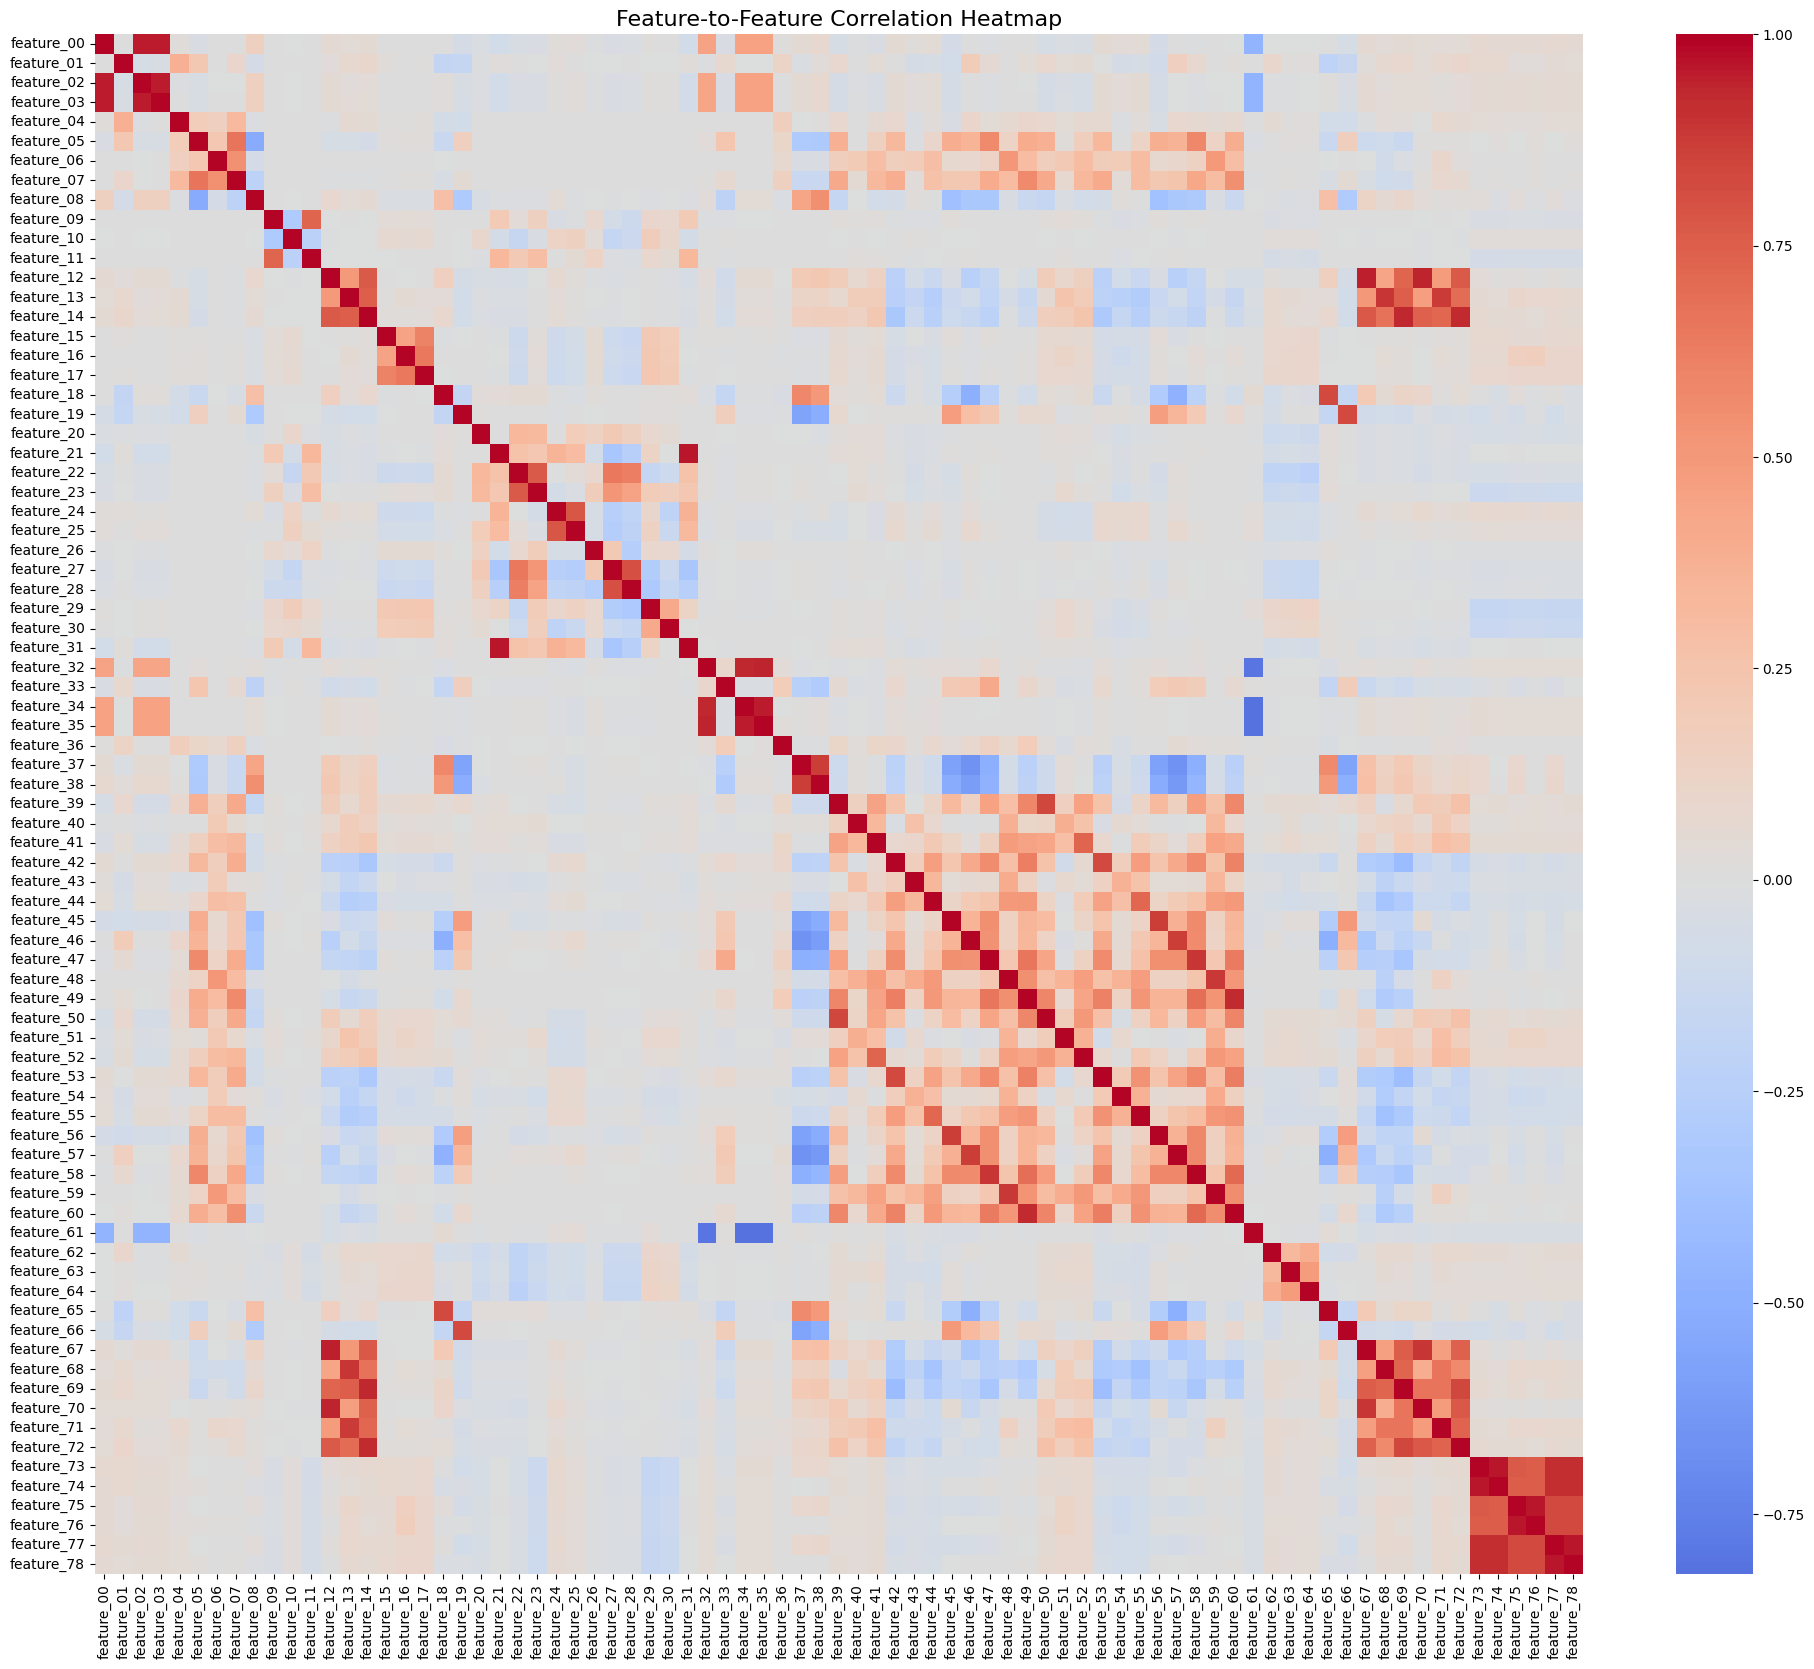

CPU times: user 1min 32s, sys: 1.31 s, total: 1min 33s
Wall time: 1min 33s


In [15]:
%%time
feature_corr = train[feature_columns].corr(method ='pearson')

plt.figure(figsize=(24, 20))
sns.heatmap(feature_corr, cmap="coolwarm", annot=False, center=0)
plt.title("Feature-to-Feature Correlation Heatmap", fontsize=16)
plt.show()

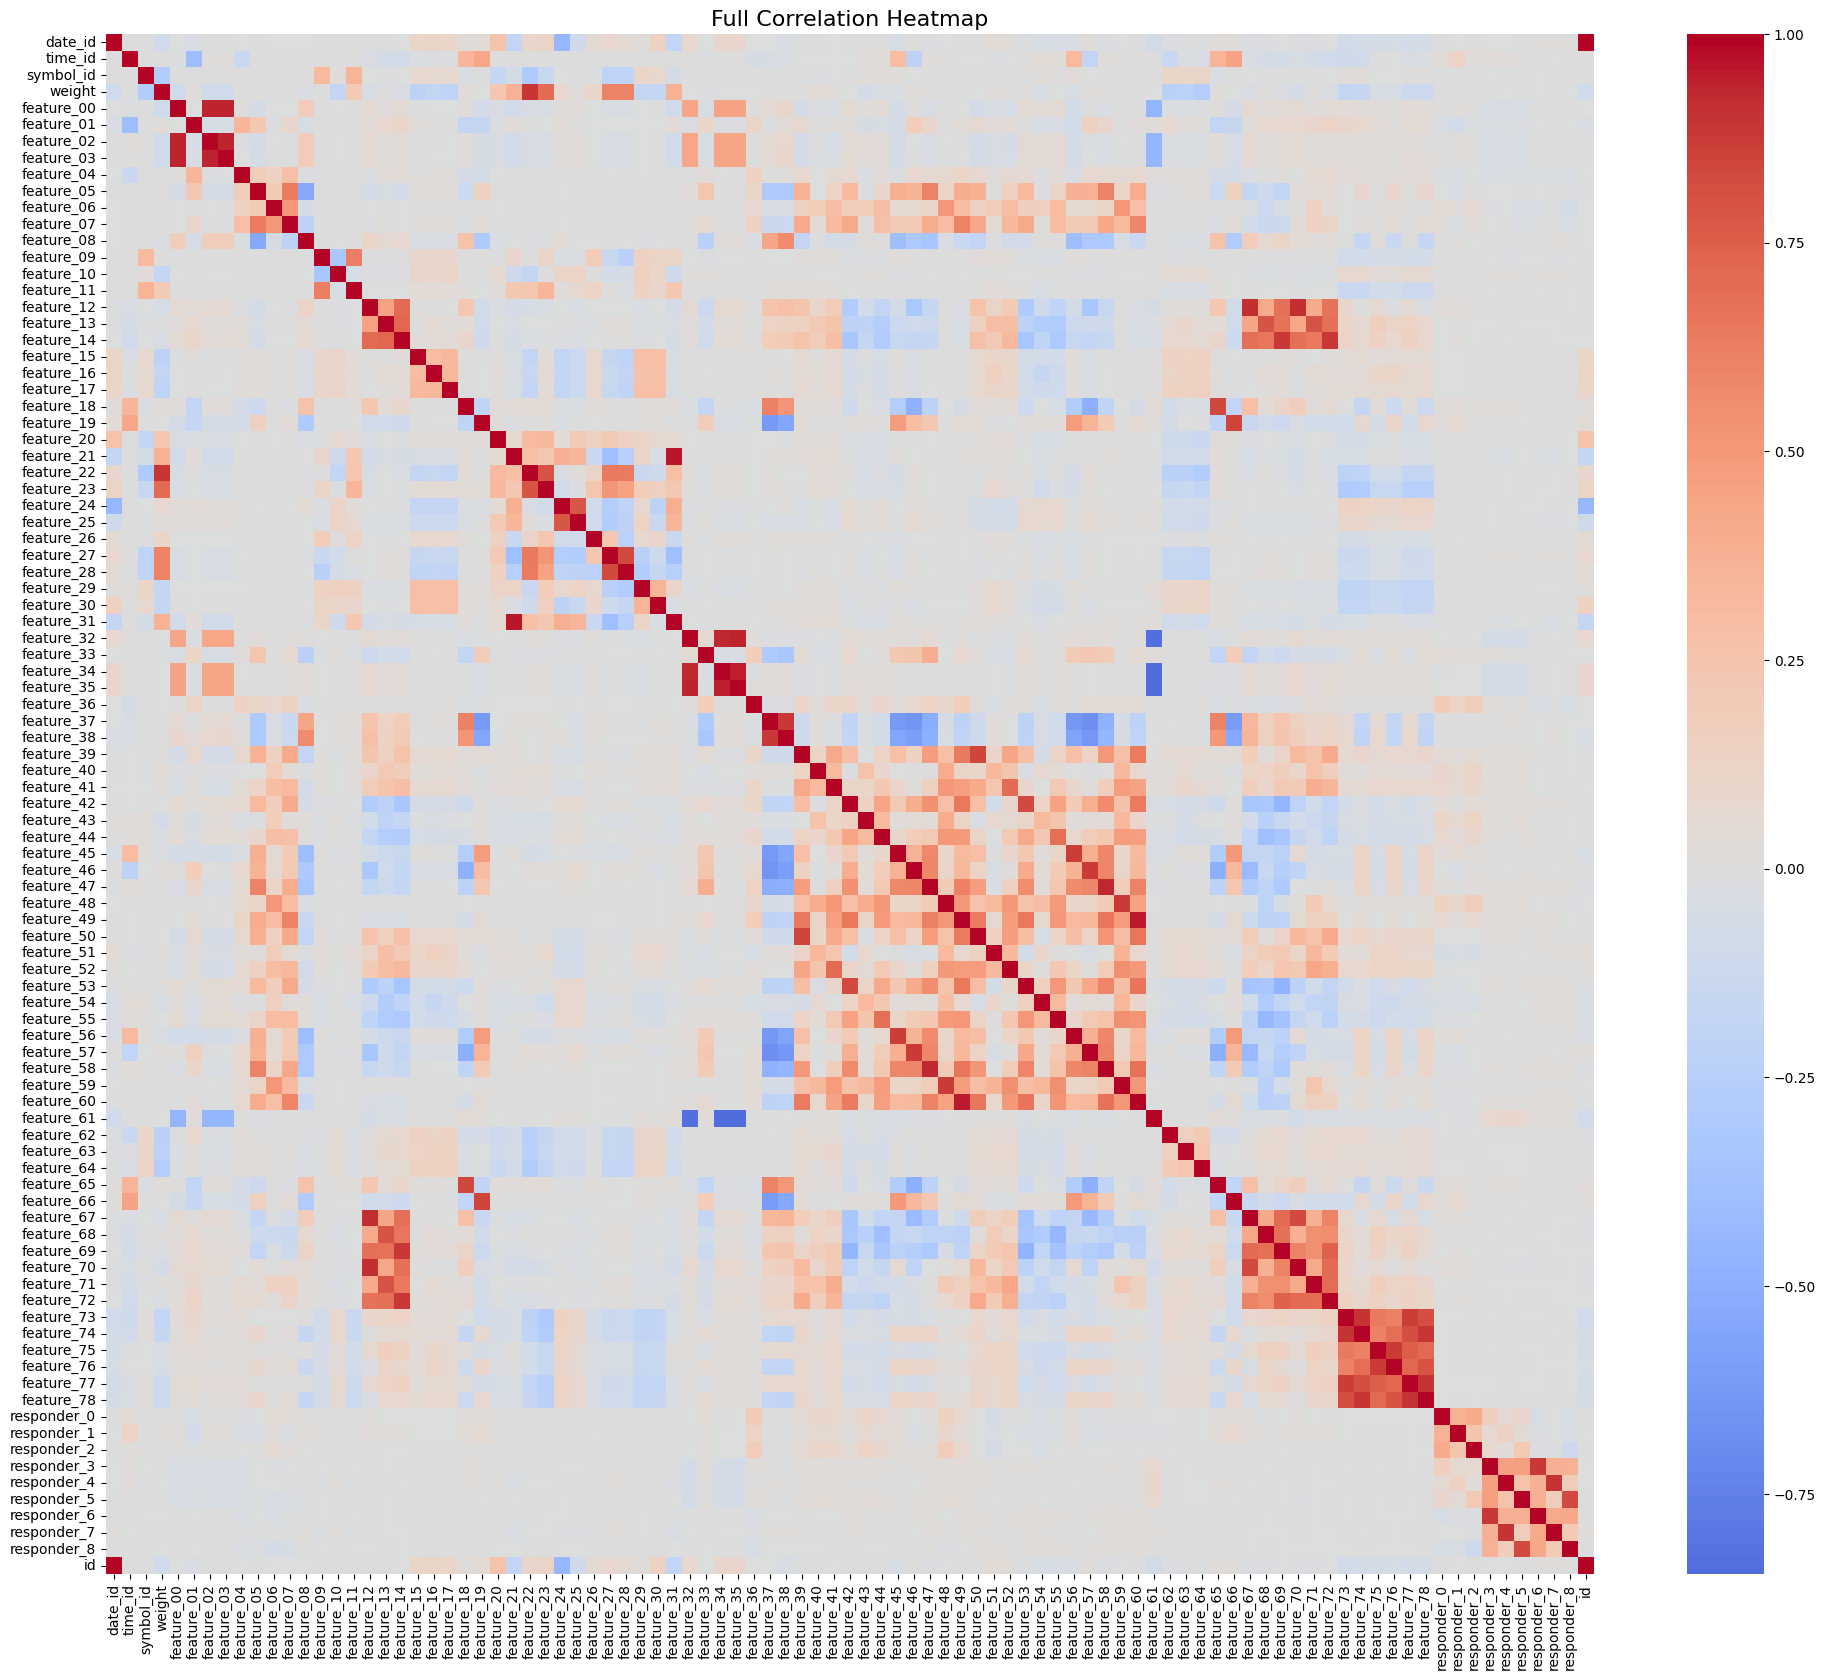

CPU times: user 1h 48min 26s, sys: 3min 15s, total: 1h 51min 41s
Wall time: 1h 51min 40s


In [16]:
%%time
full_corr_s = train.corr(method='spearman')

plt.figure(figsize=(24, 20))
sns.heatmap(full_corr_s, cmap="coolwarm", annot=False, center=0)
plt.title("Full Correlation Heatmap", fontsize=16)
plt.show()

Their is no correlation between features and Responder_6, 0.03 being pretty low 

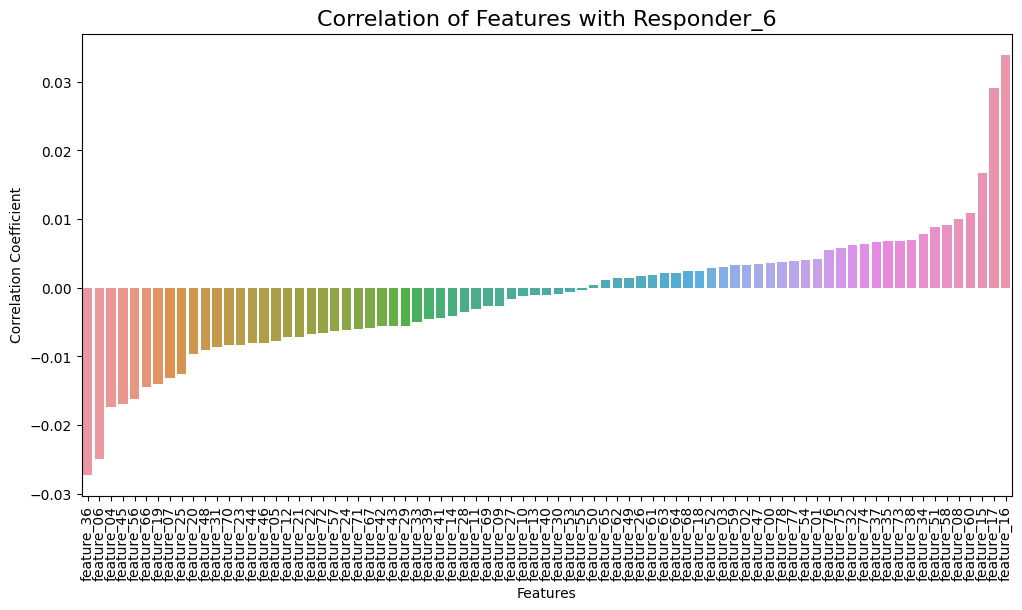

In [17]:
correlation_with_responder = train[feature_columns + ['responder_6']].corr()

responder_corr = correlation_with_responder['responder_6'].drop('responder_6').sort_values(ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=responder_corr.index, y=responder_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation of Features with Responder_6", fontsize=16)
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.show()

Full Heatmap just to see interactions between date_id, time_id, symbol_id and other responders, using pearson method 

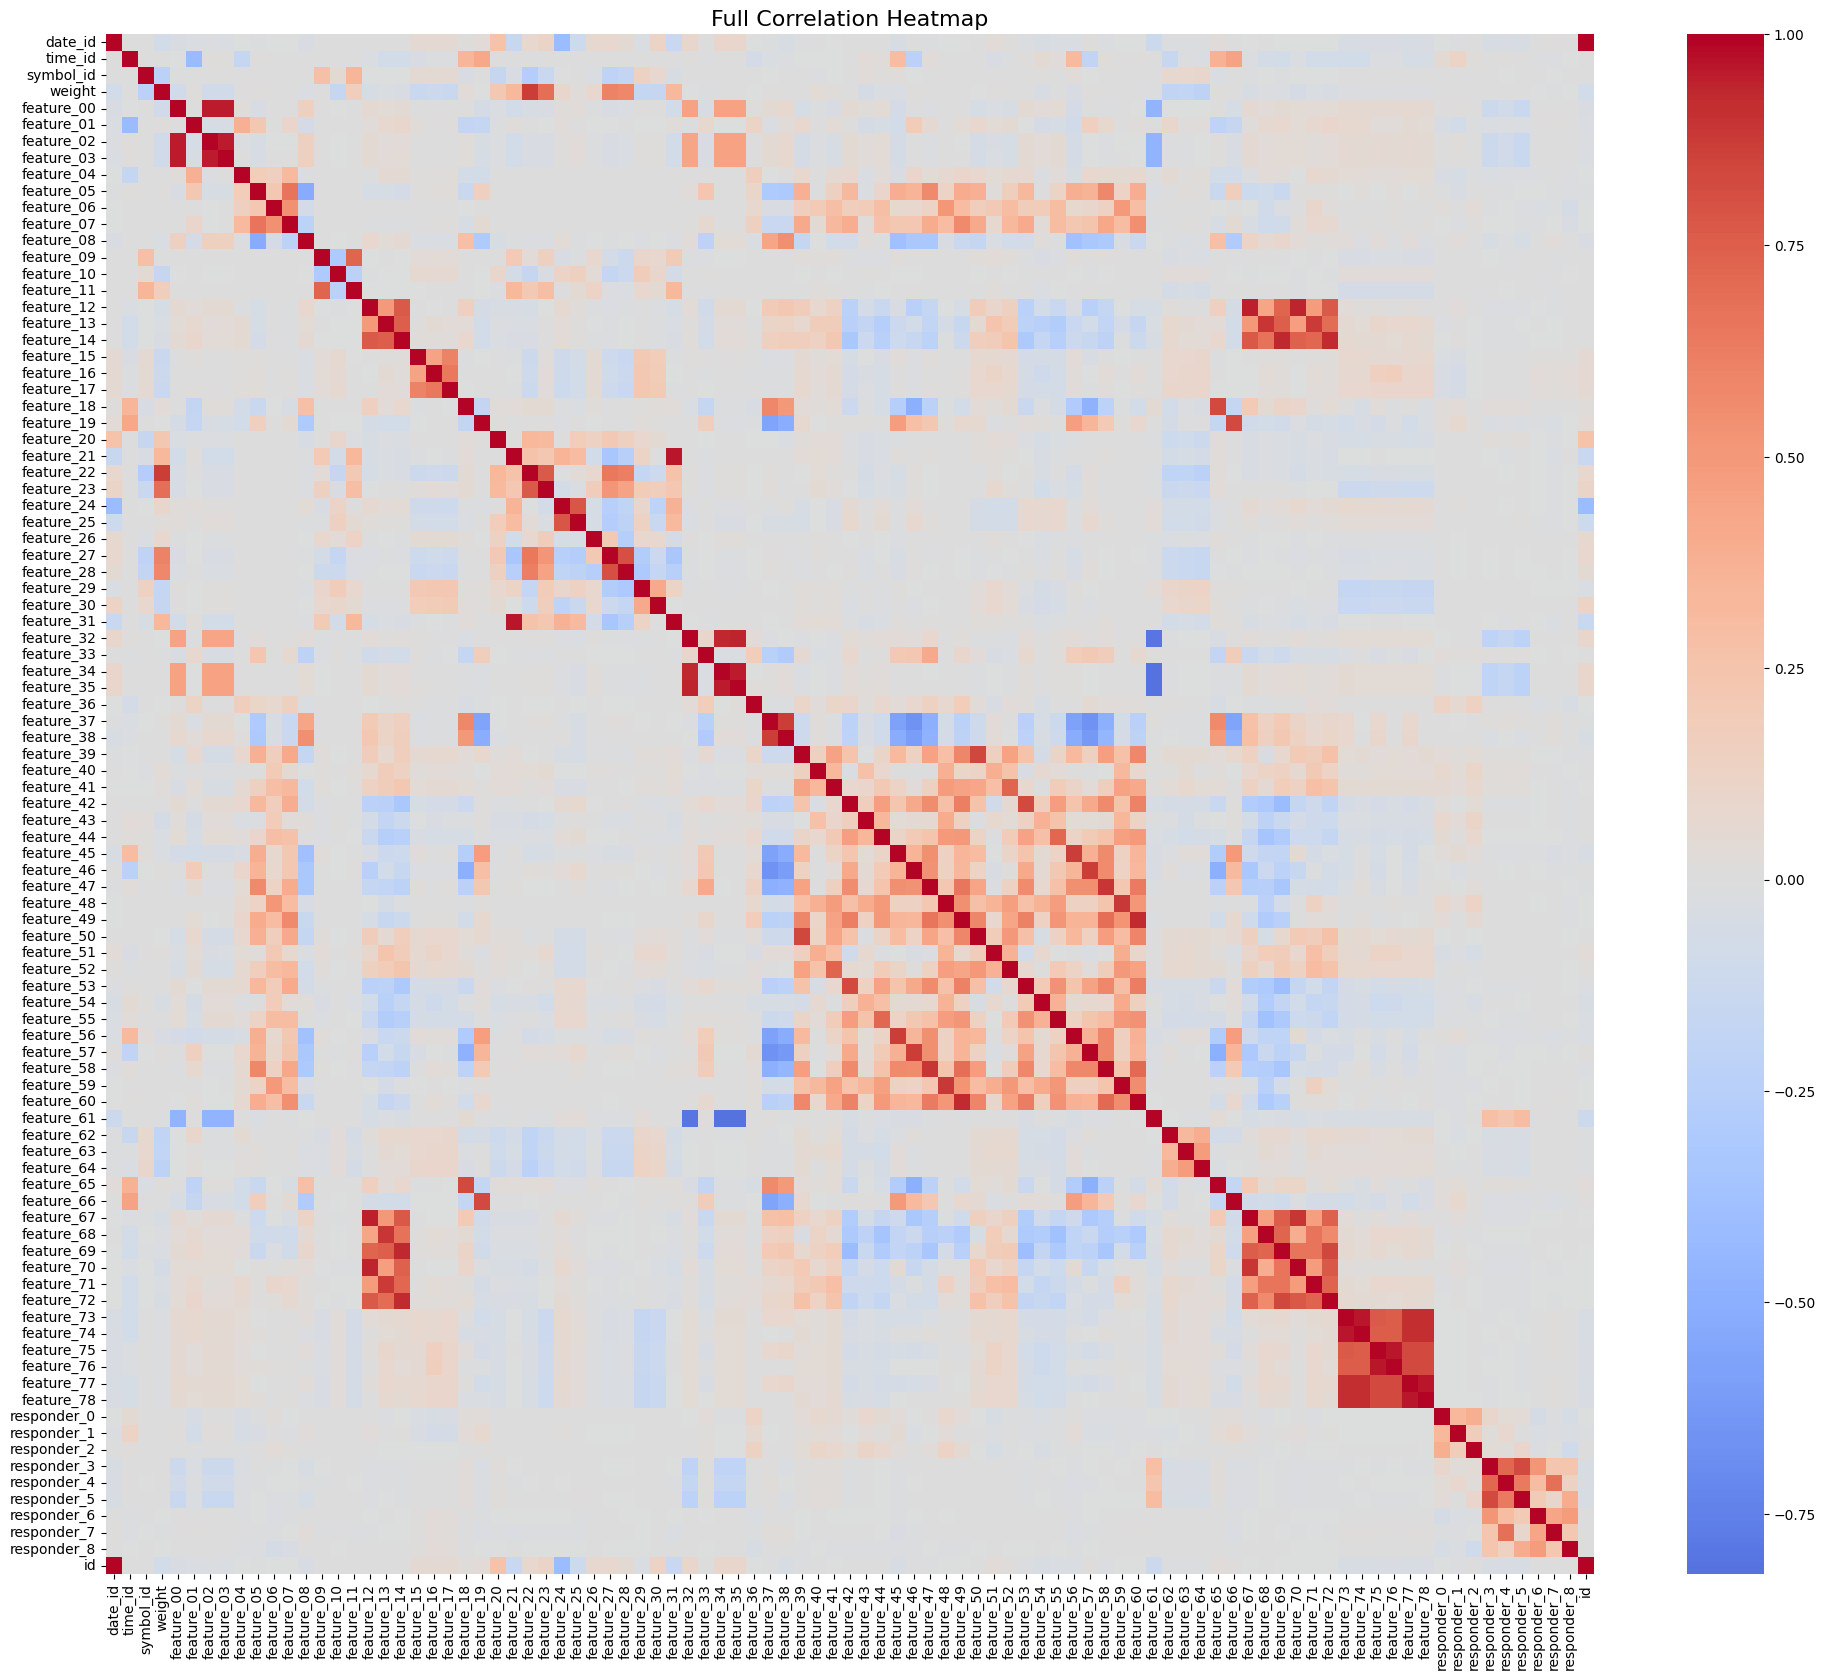

CPU times: user 2min 5s, sys: 1.02 s, total: 2min 6s
Wall time: 2min 6s


In [18]:
%%time
full_corr_p = train.corr(method ='pearson')

plt.figure(figsize=(24, 20))
sns.heatmap(full_corr_p, cmap="coolwarm", annot=False, center=0)
plt.title("Full Correlation Heatmap", fontsize=16)
plt.show()

**Responder Correlations:** 
responder_6 is strongly correlated with responder_3, responder_7, and responder_8.

**Feature Clusters:**-
feature_73 to feature_78 are highly correlated.
feature_50-60 each correlate with feature_39-49 respectively.

**Moderate Correlations:**
feature_72 to feature_67 are all moderately correlated and also with feature_12, feature_13, and feature_14.
feature_65 with feature_18, feature_66 with feature_19.

**Other Pairs:**
feature_02 and feature_03 with feature_00.
feature_22 with weight.

As found previously, responders 3, 8 and 7 may share a similar pattern with responder_6.
Also the negative correlations are too weak to indicate strong inverse relationships with responder_6. These columns are unlikely to play a significant role so they may have limited utility for the final model.

In [19]:
combined_corr =  full_corr_s
#combined_corr = (full_corr_p + full_corr_p) / 2

combined_corr_responder = combined_corr['responder_6'].drop('responder_6').abs().sort_values(ascending=False)
top_10_features = combined_corr_responder.head(15)

print("Top 15 Features with highest mean (spearman) correlation:")
print(top_10_features)

Top 15 Features with highest mean (spearman) correlation:
responder_3    0.879281
responder_8    0.429841
responder_7    0.420373
responder_5    0.374870
responder_4    0.373215
responder_0    0.049886
feature_36     0.034428
feature_06     0.034329
feature_58     0.030093
feature_60     0.027501
feature_04     0.026738
feature_53     0.026116
feature_47     0.023778
responder_2    0.023175
responder_1    0.020733
Name: responder_6, dtype: float64


In [20]:
combined_corr = full_corr_p 
#combined_corr = (full_corr_p + full_corr_p) / 2

combined_corr_responder = combined_corr['responder_6'].drop('responder_6').abs().sort_values(ascending=False)
top_10_features = combined_corr_responder.head(15)

print("Top 15 Features with highest mean (pearson) correlation:")
print(top_10_features)

Top 15 Features with highest mean (pearson) correlation:
responder_3    0.518503
responder_8    0.481380
responder_7    0.441515
responder_4    0.299350
responder_5    0.196772
responder_0    0.055063
feature_16     0.033946
feature_17     0.029086
responder_1    0.027608
feature_36     0.027210
feature_06     0.024966
responder_2    0.022506
feature_04     0.017309
feature_45     0.016949
feature_15     0.016702
Name: responder_6, dtype: float64


Could be a good idea to perform feature selection, and delete the ones that have very low correlations, to avoid adding unnecessary noise to the model.

In [21]:
combined_corr = (full_corr_p + full_corr_s) / 2
#combined_corr = (full_corr_p + full_corr_p) / 2

combined_corr_responder = combined_corr['responder_6'].drop('responder_6').abs().sort_values(ascending=False)
top_10_features = combined_corr_responder.head(10)
bottom_10_features = combined_corr_responder.tail(10)

print("Top 10 Features with highest mean (spearman + pearson) correlation:")
print(top_10_features)
print("Bottom 10 Features with lowest mean (spearman + pearson) correlation:")
print(bottom_10_features)

Top 10 Features with highest mean (spearman + pearson) correlation:
responder_3    0.698892
responder_8    0.455610
responder_7    0.430944
responder_4    0.336282
responder_5    0.285821
responder_0    0.052474
feature_36     0.030819
feature_06     0.029648
responder_1    0.024170
responder_2    0.022840
Name: responder_6, dtype: float64
Bottom 10 Features with lowest mean (spearman + pearson) correlation:
feature_44    0.000972
feature_38    0.000803
feature_37    0.000660
feature_77    0.000619
feature_65    0.000476
feature_62    0.000476
feature_46    0.000406
feature_30    0.000396
feature_28    0.000321
feature_68    0.000097
Name: responder_6, dtype: float64


These highly correlated features may contain redundant information, which can impact modeling performance. Dimensionality reduction techniques like PCA or even feature deletion/selection may help improving the final model.

In [22]:
threshold = 0.9
high_corr_pairs = []

for i in range(len(combined_corr.columns)):
    for j in range(i):
        if combined_corr.iloc[i, j] > threshold:
            high_corr_pairs.append((combined_corr.columns[i], combined_corr.columns[j], combined_corr.iloc[i, j]))


print(f"Highly Correlated Column Pairs (|corr| > {threshold}:")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

Highly Correlated Column Pairs (|corr| > 0.9:
feature_02 - feature_00: 0.94
feature_03 - feature_00: 0.95
feature_03 - feature_02: 0.95
feature_31 - feature_21: 0.96
feature_34 - feature_32: 0.93
feature_35 - feature_32: 0.94
feature_35 - feature_34: 0.95
feature_58 - feature_47: 0.91
feature_60 - feature_49: 0.94
feature_67 - feature_12: 0.93
feature_69 - feature_14: 0.91
feature_70 - feature_12: 0.93
feature_72 - feature_14: 0.91
feature_74 - feature_73: 0.93
feature_76 - feature_75: 0.92
feature_78 - feature_74: 0.90
feature_78 - feature_77: 0.93
id - date_id: 1.00


We can talk about denser central areas where values cluster tightly near the mean, or even the present vertical symmetry, but as observed earlier, there is no strong correlation between the features and responder_6. Even for the features with relatively higher (but still weak) correlations, plotting them does not reveal any clear patterns or significant relationships.


Top 9 Features Most Correlated with Responder_6 (features only): ['feature_36', 'feature_06', 'feature_04', 'feature_58', 'feature_60', 'feature_16', 'feature_17', 'feature_07', 'feature_47']


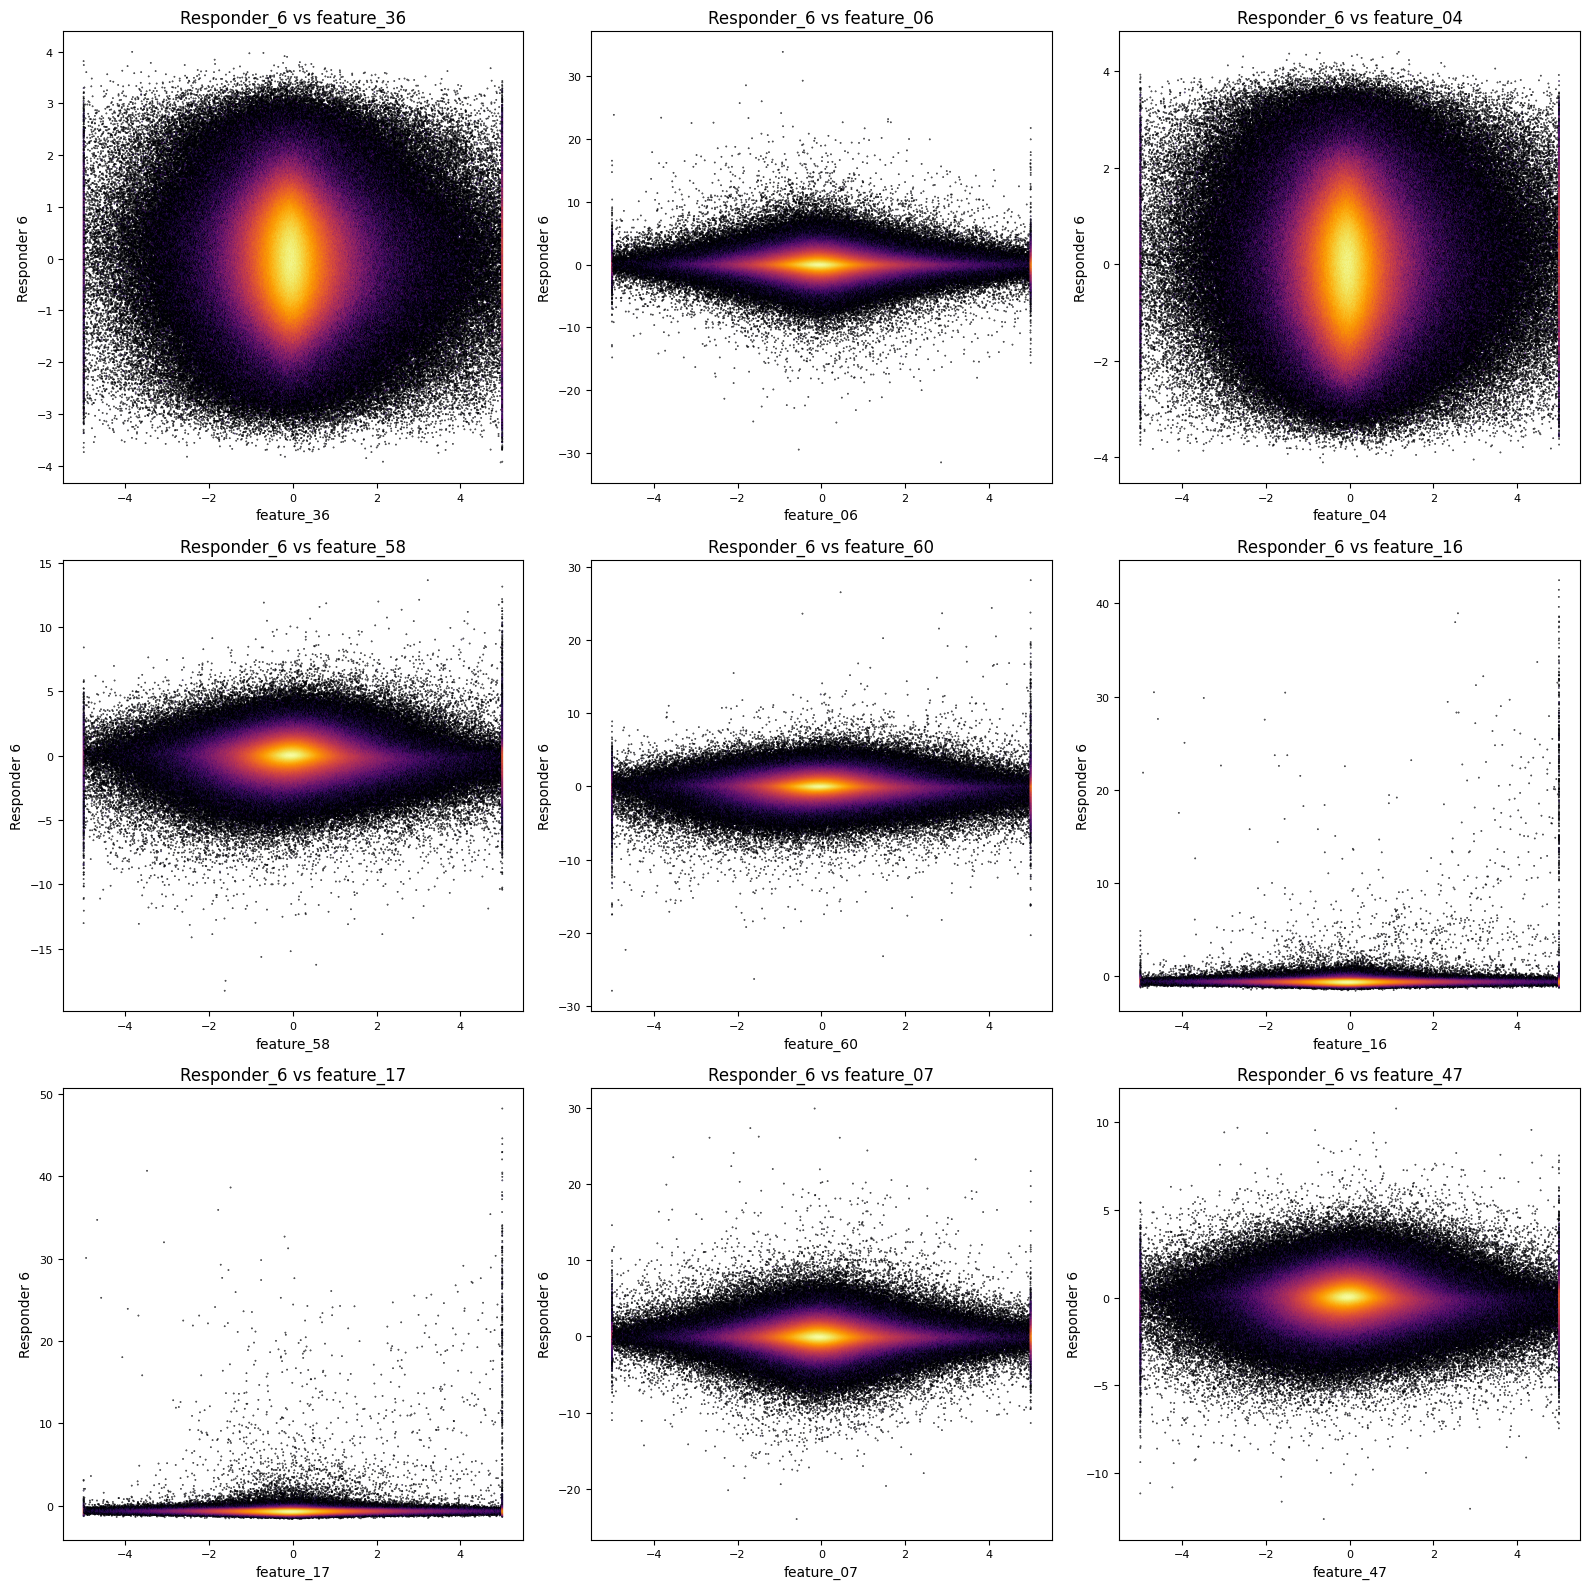

In [23]:
combined_corr_responder = combined_corr['responder_6'].drop('responder_6').abs().sort_values(ascending=False)
combined_corr_features = combined_corr_responder[combined_corr_responder.index.str.contains('feature')].abs().sort_values(ascending=False)

top_9_features = combined_corr_features.head(9).index.tolist()
print("Top 9 Features Most Correlated with Responder_6 (features only):", top_9_features)

plt.figure(figsize=(16, 16))
for i, feature in enumerate(top_9_features, 1):
    plt.subplot(3, 3, i)
    plt.hexbin(train['responder_6'], train[feature],gridsize=1000, bins='log', cmap='inferno')
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Responder 6', fontsize=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    plt.title(f"Responder_6 vs {feature}", fontsize=12)

plt.tight_layout()
plt.show()

## Statistical Tests

**Neyman-Pearson Test**

This example illustrates a Neyman-Pearson test for correlation in the classical theoretical sense. This involves several strong/false assumptions and limitations that differ from the practical implementation.

- Simple Hypotheses

The Neyman-Pearson lemma applies only to simple vs. simple hypotheses. We must specify:
$$ H_0: \rho = \rho_1 \text{ and } H_1: \rho = \rho_1 $$

where $\rho_0$ and $\rho_1$ are both known, fixed constants, and $\rho_0 \neq \rho_1$. For example, we might choose $\rho_0 = 0$ and $\rho_1 = 0.1$.

- Model Assumptions ( totally biased and in opposition to the previous analysis )

Assume $(X_i, Y_i)$ are i.i.d. from a bivariate normal distribution.
Under $H_0$: $\rho = 0$, so $(X_i, Y_i)$ are independent standard normals. Under $H_1$: $\rho = \rho_1$, known and fixed.

- Neyman-Pearson Lemma and Likelihood Ratio Test

The Neyman-Pearson lemma states that the most powerful test for these two simple hypotheses is a likelihood ratio test:

$$ \Lambda = \frac{L(X_1,\ldots,X_n,Y_1,\ldots,Y_n|\rho=\rho_1)}{L(X_1,\ldots,X_n,Y_1,\ldots,Y_n|\rho=0)}$$

Reject $H_0$ if $\Lambda > k$ for some critical value $k$ determined by the size $\alpha$.

For a bivariate normal model:
Under $H_0$, the joint density of each pair is:
       $
            f_0(x,y) = \frac{1}{2\pi}e^{-(x^2+y^2)/2}
        $
    Under $H_1$, the joint density is:
    $$ f_1(x,y) = \frac{1}{2\pi\sqrt{1-\rho_1^2}}\exp\left(-\frac{x^2-2\rho_1xy+y^2}{2(1-\rho_1^2)}\right)$$


The likelihood ratio for the entire sample is:
$$\Lambda = \left(\frac{1}{1-\rho_1^2}\right)^{n/2}\exp\left(-\frac{\sum(x_i^2-2\rho_1x_iy_i+y_i^2)}{2(1-\rho_1^2)}+\frac{\sum(x_i^2+y_i^2)}{2}\right)$$

This simplifies and can be expressed in terms of the sample correlation:
$r = \frac{\sum x_iy_i}{\sqrt{\sum x_i^2\sum y_i^2}}$

- Determining the Critical Value

To have a size $\alpha$ test, we solve:
$ P_{H_0}(\Lambda > k) = \alpha $

This can be done using Fisher's z-transform:
$$Z = \frac{1}{2}\ln\left(\frac{1+r}{1-r}\right) \sim N\left(0,\frac{1}{n-3}\right)$$

under $H_0$. For a chosen $\alpha$, find the critical z-value $z_\alpha$ and translate that back to a threshold on $r$. Under $H_1$, the distribution of $Z$ shifts, ensuring this test is the most powerful for detecting $\rho_1$ specifically.

Based on previous correlation analysis, i will only experiment on 10 best 

In [24]:
top_10_features.index.tolist()

['responder_3',
 'responder_8',
 'responder_7',
 'responder_4',
 'responder_5',
 'responder_0',
 'feature_36',
 'feature_06',
 'responder_1',
 'responder_2']

With so much data, the test finds even tiny positive correlations significant, while negative ones do not pass the threshold. Since the sample is huge, the test is incredibly sensitive and has essentially perfect power. However, this also means that even very small effects appear significant, so the practical importance of these correlations might be questionable to not say useless.

In [25]:
alpha = 0.05
rho_1 = 0.1
responder_name = "responder_6"

responders_to_test = top_10_features.index.tolist()

results_list = []

for feature_name in responders_to_test:
    df_pair = train[[responder_name, feature_name]].dropna()
    X = df_pair[feature_name].values
    Y = df_pair[responder_name].values
    n = len(X)

    r = np.corrcoef(X, Y)[0,1]
    Z_obs = 0.5 * log((1+r)/(1-r))
    z_alpha_standard = norm.ppf(1 - alpha)
    z_alpha = z_alpha_standard * sqrt(1/(n-3))
    reject_H0 = (Z_obs > z_alpha)
    mean_Z_h1 = 0.5 * log((1+rho_1)/(1-rho_1))
    power = 1 - norm.cdf(z_alpha, loc=mean_Z_h1, scale=sqrt(1/(n-3)))
    results_list.append({
        'Feature': feature_name,
        'N': n,
        'Correlation': r,
        'Z_Obs': Z_obs,
        'Z_Critical': z_alpha,
        'Reject_H0': reject_H0,
        'Power_at_rho1': power
    })

np_results = pd.DataFrame(results_list)
np_results

Feature        N  Correlation     Z_Obs  Z_Critical  Reject_H0  \
0  responder_3  6274576     0.518503  0.574291    0.000657       True   
1  responder_8  6274576     0.481380  0.524778    0.000657       True   
2  responder_7  6274576     0.441515  0.474111    0.000657       True   
3  responder_4  6274576     0.299350  0.308805    0.000657       True   
4  responder_5  6274576     0.196772  0.199372    0.000657       True   
5  responder_0  6274576    -0.055063 -0.055118    0.000657      False   
6   feature_36  6274576    -0.027210 -0.027217    0.000657      False   
7   feature_06  6274576    -0.024966 -0.024971    0.000657      False   
8  responder_1  6274576    -0.027608 -0.027615    0.000657      False   
9  responder_2  6274576    -0.022506 -0.022509    0.000657      False   

   Power_at_rho1  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
5            1.0  
6            1.0  
7            1.0  
8            1.0  
9            1.0

**Wald Test**

The Wald test assesses whether an estimated parameter $\hat{\theta}$ differs significantly from a hypothesized value $\theta_0$.

Suppose we have:
\begin{align*}
   H_0&: \theta = \theta_0 \text{ vs. } H_1: \theta \neq \theta_0
\end{align*}

We estimate $\theta$ from the data to get $\hat{\theta}$ and its standard error $SE(\hat{\theta})$.

The Wald statistic is:
\begin{equation}
   W_n = \frac{(\hat{\theta}_n - \theta_0)^2}{V(\hat{\theta}_n)}
\end{equation}

Under $H_0$, $W_n$ converges in distribution to a $\chi^2(1)$.
The Wald test thus follows an asymptotic $\chi^2(1)$ distribution under $H_0$.

The Wald test results show that all features have statistically significant relationships with responder_6, as all p-values are 0, and Hypothesis0 is rejected for every feature. Features like responder_3, responder_8, and responder_7 exhibit particularly strong effects as before, and as reflected by their large slopes and high Wald statistics. As of features_16 and features_17, who seems to be most significant features.

In [26]:
responder_name = "responder_6"
responders_to_test = top_10_features.index.tolist()

results_list = []

for feature_name in responders_to_test:
    df_pair = train[[responder_name, feature_name]].dropna()
    X = df_pair[feature_name].values
    Y = df_pair[responder_name].values
    n = len(X)
    
    X_with_const = sm.add_constant(X)
    model = sm.OLS(Y, X_with_const).fit()
    
    slope = model.params[1]
    se = model.bse[1]
    wald_stat = (slope ** 2) / (se ** 2)  
    p_val = 1 - chi2.cdf(wald_stat, df=1)  
    
    alpha = 0.05
    reject_H0 = p_val < alpha

    results_list.append({
        'Feature': feature_name,
        'N': n,
        'Slope': slope,
        'SE': se,
        'Wald_Stat': wald_stat,
        'P_Value': p_val,
        'Reject_H0': reject_H0
    })

wald_results = pd.DataFrame(results_list)
wald_results

Feature        N     Slope        SE     Wald_Stat  P_Value  Reject_H0
0  responder_3  6274576  0.416135  0.000274  2.307165e+06      0.0       True
1  responder_8  6274576  0.492691  0.000358  1.892533e+06      0.0       True
2  responder_7  6274576  0.433819  0.000352  1.519306e+06      0.0       True
3  responder_4  6274576  0.259186  0.000330  6.176095e+05      0.0       True
4  responder_5  6274576  0.164781  0.000328  2.527310e+05      0.0       True
5  responder_0  6274576 -0.107631  0.000779  1.908162e+04      0.0       True
6   feature_36  6274576 -0.027394  0.000402  4.649060e+03      0.0       True
7   feature_06  6274576 -0.019457  0.000311  3.913359e+03      0.0       True
8  responder_1  6274576 -0.053494  0.000773  4.785967e+03      0.0       True
9  responder_2  6274576 -0.042905  0.000761  3.179710e+03      0.0       True

**Permutation Importance**

Permutation importance is a model-agnostic technique to assess the significance of features in a predictive model. It measures how much the model's performance deteriorates when the values of a particular feature are randomly shuffled, breaking its relationship with the target variable.

- Compute Baseline Error
Evaluate the model's performance using the unaltered dataset to get the baseline error:
\begin{equation}
   \text{Baseline Error} = \text{Metric}(y, \hat{y})
\end{equation}
where $y$ are the true values and $\hat{y}$ are the model's predictions.

- Permute Feature Values
For each feature $X_j$, shuffle its values randomly to create a modified dataset $\tilde{X}_j$. This destroys any relationship between $X_j$ and the target $y$.

- Compute Permutation Error
Evaluate the model's performance using the dataset with permuted $X_j$:
\begin{equation}
   \text{Permuted Error}_j = \text{Metric}(y, \hat{y}^{\text{perm}})
\end{equation}
where $\hat{y}^{\text{perm}}$ are the model's predictions on the permuted dataset.

- Calculate Importance
The importance of feature $X_j$ is quantified by the increase in error:
\begin{equation}
   \Delta_j = \text{Permuted Error}_j - \text{Baseline Error}
\end{equation}

- Repeat for Stability
Repeat the permutation process multiple times to estimate the mean and standard deviation of $\Delta_j$.

The permutation importance analysis shows that responder_3 is the most critical feature, with a large impact on model performance $(ΔMSE=1.45)$. responder_5, responder_8, and responder_7 also significantly contribute, while features like feature_16 and feature_17 have minimal impact $(ΔMSE≈0)$. The consistency between both results confirms the robustness of these findings.

In [27]:
X = train[top_10_features.index.tolist()]
y = train['responder_6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

baseline_mse = mean_squared_error(y_test, lgb_model.predict(X_test))
print(f"Baseline MSE: {baseline_mse}")

perm_importance = permutation_importance(lgb_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std_Dev': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)
print("Permutation Importance sklearn:")
print(perm_importance_df)

results_list = []
for feature_name in top_10_features.index.tolist():

    X_test_permuted = X_test.copy()
    X_test_permuted[feature_name] = np.random.permutation(X_test_permuted[feature_name])
    
    y_pred_permuted = lgb_model.predict(X_test_permuted)
    permuted_mse = mean_squared_error(y_test, y_pred_permuted)
    delta_mse = permuted_mse - baseline_mse
    
    results_list.append({
        'Feature': feature_name,
        'Baseline_MSE': baseline_mse,
        'Permuted_MSE': permuted_mse,
        'Delta_MSE': delta_mse
    })

custom_perm_df = pd.DataFrame(results_list).sort_values(by='Delta_MSE', ascending=False)
print("\nCustom Permutation Importance:")
print(custom_perm_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 5019660, number of used features: 10
[LightGBM] [Info] Start training from score -0.003777
Baseline MSE: 0.069085439136442
Permutation Importance sklearn:
       Feature  Importance   Std_Dev
0  responder_3    2.157966  0.002845
4  responder_5    0.293525  0.000487
1  responder_8    0.172183  0.000512
2  responder_7    0.089682  0.000242
5  responder_0    0.069062  0.000139
3  responder_4    0.021419  0.000109
8  responder_1    0.000360  0.000013
6   feature_36    0.000105  0.000006
9  responder_2    0.000103  0.000008
7   feature_06    0.000055  0.000002

Custom Permutation Importance:
       Feature  Baseline_MSE  Permuted_MSE  Delta_MSE
0  responder_3      0.069085      1.500043   1.430958
4  responder_5      0.069085      0.263952  

## Prediction/ Conclusion

In this notebook, we explored the relationships between features and responder_6 using different methods. Features like responder_3, responder_8, and feature_36, feature_16 and feature_17 were identified as highly correlated with responder_6, confirmed through both Pearson and Spearman correlations. Statistical tests (which have limitations due to incorrect assumptions being made), including Neyman-Pearson and permutation importance, validated these findings and demonstrated the significance of the selected features. Feature engineering, such as interaction terms and time-based sinusoidal features, further enhanced the model's performance. A LightGBM model successfully predicted responder_6, confirming the relevance of the chosen features. Overall, we addressed the initial hypothesis by identifying significant relationships between certain features and responder_6 and validating them with statistical methods.


Let's perform predictions on the responder_6 target variable using a LGBM model. It incorporates feature engineering techniques and important features identified earlier.

In [28]:
%%time

responders = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv')
features = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv')
sample_submission = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv')

train = (
    pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=9/part-0.parquet')
).to_pandas()

# LightGBM Parameters
lgb_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "random_state": 9,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "num_leaves": 64,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "min_child_weight": 10,
    "device": "gpu", 
}

# Important Features 
important_features = [
    'symbol_id', 'feature_16', 'feature_17', 'feature_36', 
    'responder_3', 'responder_7', 'responder_8'
]


train['feature_16_17_interaction'] = train['feature_16'] * train['feature_17']
train['responder_avg'] = (
    train['responder_3'] + train['responder_7'] + train['responder_8']
) / 3
train['sin_time_id'] = np.sin(2 * np.pi * train['time_id'] / 967)
train['cos_time_id'] = np.cos(2 * np.pi * train['time_id'] / 967)


final_feature = important_features + [
    'feature_16_17_interaction', 'responder_avg', 'sin_time_id', 'cos_time_id'
]
train = train[['responder_6'] + final_feature]


lgb_model = LGBMRegressor(**lgb_params)
lgb_model.fit(train[final_feature], train['responder_6'])


def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame:
    global lags_
    if lags is not None:
        lags_ = lags

    test_df = test.to_pandas()


    for col in important_features + ['time_id']:
        if col not in test_df.columns:
            test_df[col] = 0

    test_df['feature_16_17_interaction'] = test_df['feature_16'] * test_df['feature_17']
    test_df['responder_avg'] = (
        test_df['responder_3'] + test_df['responder_7'] + test_df['responder_8']
    ) / 3
    test_df['sin_time_id'] = np.sin(2 * np.pi * test_df['time_id'] / 967)
    test_df['cos_time_id'] = np.cos(2 * np.pi * test_df['time_id'] / 967)

    test_df = test_df[final_feature].fillna(-1)
    predictions = lgb_model.predict(test_df)
    predictions = np.clip(predictions, -5, 5)

    predictions_df = test.select(
        'row_id',
        pl.Series('responder_6', predictions),
    )

    assert isinstance(predictions_df, (pl.DataFrame, pd.DataFrame)), "Predictions must be a Polars or Pandas DataFrame."
    print("Predictions are a Polars or Pandas DataFrame.")

    assert list(predictions_df.columns) == ['row_id', 'responder_6'], "Predictions must have columns ['row_id', 'responder_6']."
    print("Predictions have the correct columns ['row_id', 'responder_6'].")

    assert len(predictions_df) == len(test), "Predictions must have the same number of rows as the test data."
    print("Predictions have the same number of rows as the test data.")

    return predictions_df


inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2588
[LightGBM] [Info] Number of data points in the train set: 6274576, number of used features: 11
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (71.81 MB) transferred to GPU in 0.086602 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.003780
Predictions are a Polars or Pandas DataFrame.
Predictions have the correct columns ['row_id', 'responder_6'].
Predictions have the same number of rows as the test data.
CPU times: user 2min 52s, sys: 7.17 s, total: 2min 59s
Wall time: 1min 26s


/kaggle/input/jane-street-real-time-market-data-forecasting/kaggle_evaluation/core/templates.py:128: RuntimeWarning: 7681 seconds elapsed before server startup.
                This exceeds the startup time limit of 900 seconds that the gateway will enforce
                during the rerun on the hidden test set. Start the server before performing any time consuming steps.
  warnings.warn(


In [29]:
print('EOF')

EOF
